<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/MobileNet333.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://gitlab.com/milicasopalovic/emotion-detection.git

Cloning into 'emotion-detection'...
remote: Enumerating objects: 34075, done.
remote: Counting objects: 100% (34075/34075), done.
remote: Compressing objects: 100% (34074/34074), done.
remote: Total 34075 (delta 8), reused 34052 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34075/34075), 58.32 MiB | 28.81 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (35891/35891), done.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:
IMG_SIZE = (48, 48)
BATCH_SIZE = 32

DATASET_PATH = "./emotion-detection/dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


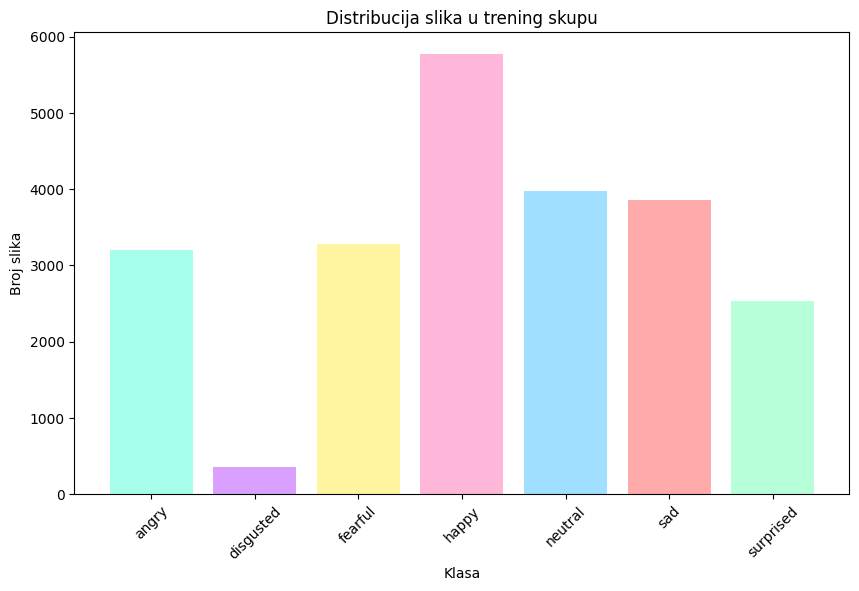

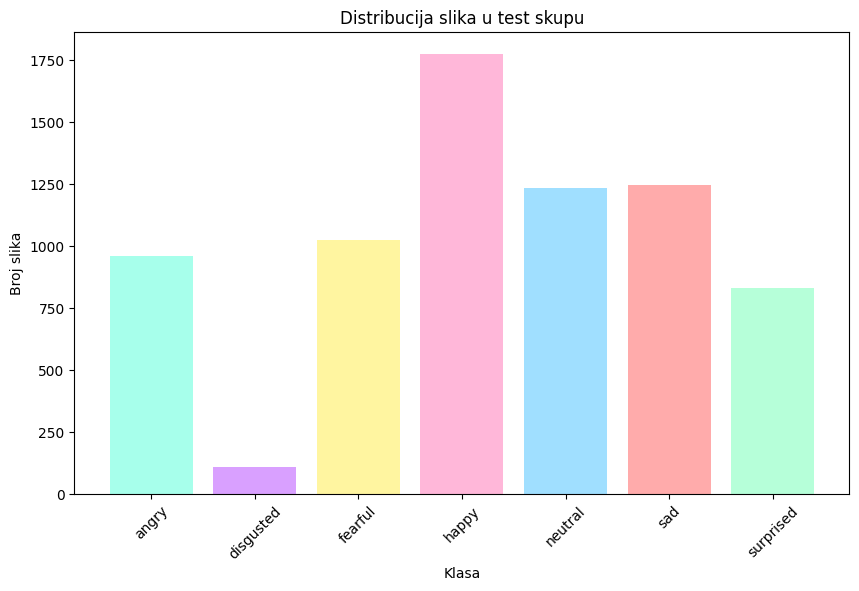

In [4]:
import matplotlib.pyplot as plt
import numpy as np


pastel_colors = ['#A7FFEB', '#D9A0FF', '#FFF5A0', '#FFB7D9', '#A0DFFF',
                 '#FFABAB', '#B6FFD9', '#F5A0FF', '#A0FFDF', '#D0A0FF']


def plot_class_distribution(generator, title):
    class_counts = np.array([sum(generator.classes == i) for i in range(len(generator.class_indices))])

    plt.figure(figsize=(10, 6))
    plt.bar(generator.class_indices.keys(), class_counts, color=pastel_colors[:len(class_counts)])
    plt.xlabel('Klasa')
    plt.ylabel('Broj slika')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator, "Distribucija slika u trening skupu")

plot_class_distribution(test_generator, "Distribucija slika u test skupu")


In [5]:
class_counts = train_generator.classes
class_weights = dict(enumerate(1.0 / np.bincount(class_counts) * len(class_counts)))

**Bez fine tuning-a:**

Gubitak kroz epohe (leva slika):

Trening gubitak je vrlo nestabilan, sa velikim oscilacijama i visokim vrednostima, što može ukazivati na problem sa optimizacijom modela.
Validacioni gubitak je vrlo nizak i gotovo konstantan, što može ukazivati da model ne uči dobro iz podataka.


Tačnost kroz epohe (desna slika):

Trening tačnost pokazuje velike oscilacije, što može značiti da model ima problema sa konvergencijom i stabilnošću učenja.
Validaciona tačnost se povećava tokom epoha i deluje stabilnije, ali je generalno niska (oko 30-35%), što znači da model nije dovoljno dobar.


In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)


<ipython-input-6-e4d2f5c45e73>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/717 ━━━━━━━━━━━━━━━━━━━━ 64s 70ms/step - accuracy: 0.1853 - loss: 17.6475 - val_accuracy: 0.2433 - val_loss: 1.9691 - learning_rate: 1.0000e-04
Epoch 2/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2188 - loss: 15.0466

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2188 - loss: 15.0466 - val_accuracy: 0.2569 - val_loss: 1.9482 - learning_rate: 1.0000e-04
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.2283 - loss: 15.2904 - val_accuracy: 0.2731 - val_loss: 1.8920 - learning_rate: 1.0000e-04
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3438 - loss: 11.9799 - val_accuracy: 0.2759 - val_loss: 1.8884 - learning_rate: 1.0000e-04
Epoch 5/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 75s 49ms/step - accuracy: 0.2539 - loss: 14.0371 - val_accuracy: 0.3099 - val_loss: 1.8015 - learning_rate: 1.0000e-04
Epoch 6/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2188 - loss: 12.3583 - val_accuracy: 0.2959 - val_loss: 1.8258 - learning_rate: 1.0000e-04
Epoch 7/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.2631 - loss: 13.2264 - val_accuracy: 0.3085 - val_loss: 1.7884 - learning_rate: 1.0000e-04
Epoch 8/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy:

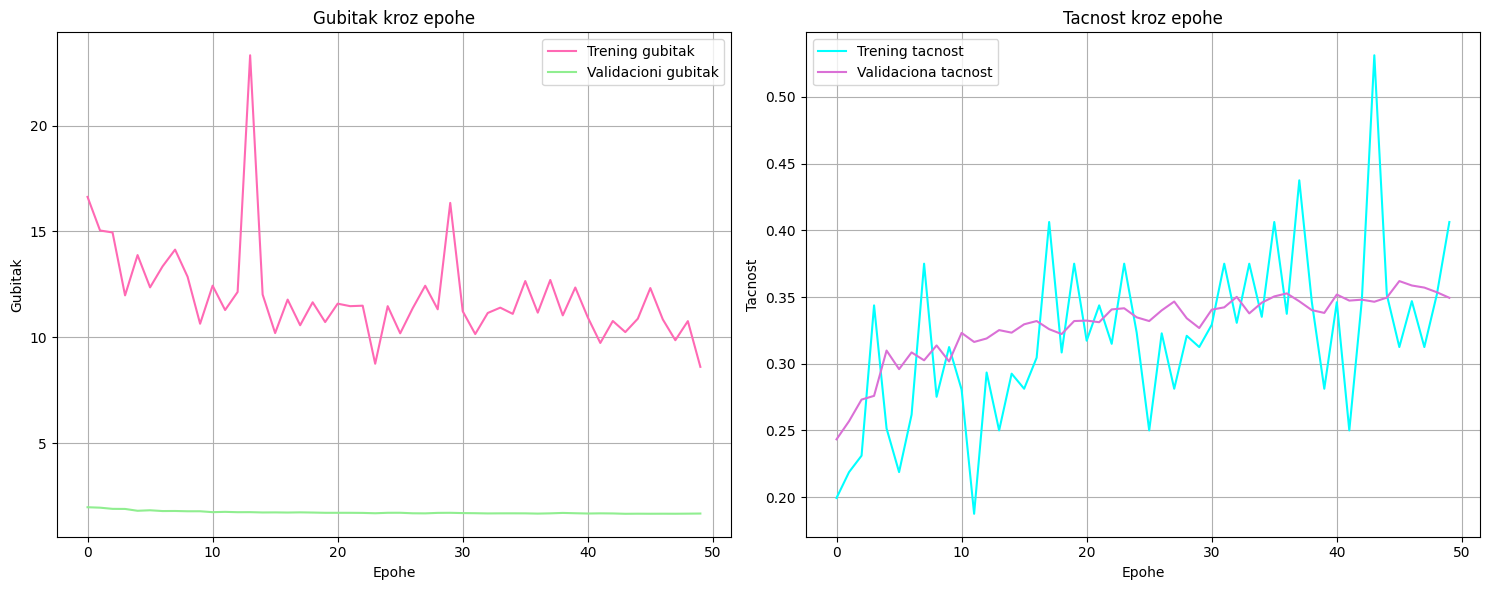

In [7]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(history.history['loss'], label='Trening gubitak', color='hotpink')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validacioni gubitak', color='lightgreen')
    axes[0].set_xlabel('Epohe')
    axes[0].set_ylabel('Gubitak')
    axes[0].set_title('Gubitak kroz epohe')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Trening tacnost', color='aqua')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validaciona tacnost', color='orchid')
    axes[1].set_xlabel('Epohe')
    axes[1].set_ylabel('Tacnost')
    axes[1].set_title('Tacnost kroz epohe')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3302 - loss: 1.6691
Test gubitak: 1.6290
Test tačnost: 0.3683


**Treniranje od nule:**

U ovom slučaju koristimo samo arhitekturu MobileNetV2, ali svi parametri se inicijalizuju slučajno i uče od nule.

1. Gubitak kroz epohe (leva slika):
Trening gubitak počinje veoma visoko i oscilira bez jasnog trenda opadanja. Ovo sugeriše da model ima poteškoća sa učenjem.
Validacioni gubitak  je skoro konstantan i veoma nizak, što može značiti da je model lose istreniran.
2. Tačnost kroz epohe (desna slika):
Trening tačnost pokazuje haotične oscilacije i u proseku je jako niska (~15-20%), što znači da model jedva nešto uči.
Validaciona tačnost brzo pada na skoro 0 i ostaje veoma niska tokom epoha, što sugeriše da model ne uspeva da generalizuje na validacionom skupu.

In [9]:
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)


Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 107s 87ms/step - accuracy: 0.1385 - loss: 18.9417 - val_accuracy: 0.2513 - val_loss: 2.2184 - learning_rate: 1.0000e-04
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1250 - loss: 18.4994 - val_accuracy: 0.2513 - val_loss: 2.2157 - learning_rate: 1.0000e-04
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - accuracy: 0.1548 - loss: 15.7389 - val_accuracy: 0.0152 - val_loss: 2.1059 - learning_rate: 1.0000e-04
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1562 - loss: 14.3467 - val_accuracy: 0.0152 - val_loss: 2.1220 - learning_rate: 1.0000e-04
Epoch 5/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.1548 - loss: 14.5763 - val_accuracy: 0.0152 - val_loss: 2.0557 - learning_rate: 1.0000e-04
Epoch 6/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2188 - loss: 12.4503 - val_accuracy: 0.0152 - val_loss: 2.0702 - learning_rate: 1.0000e-04
Epoch 7/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 75s 55ms/

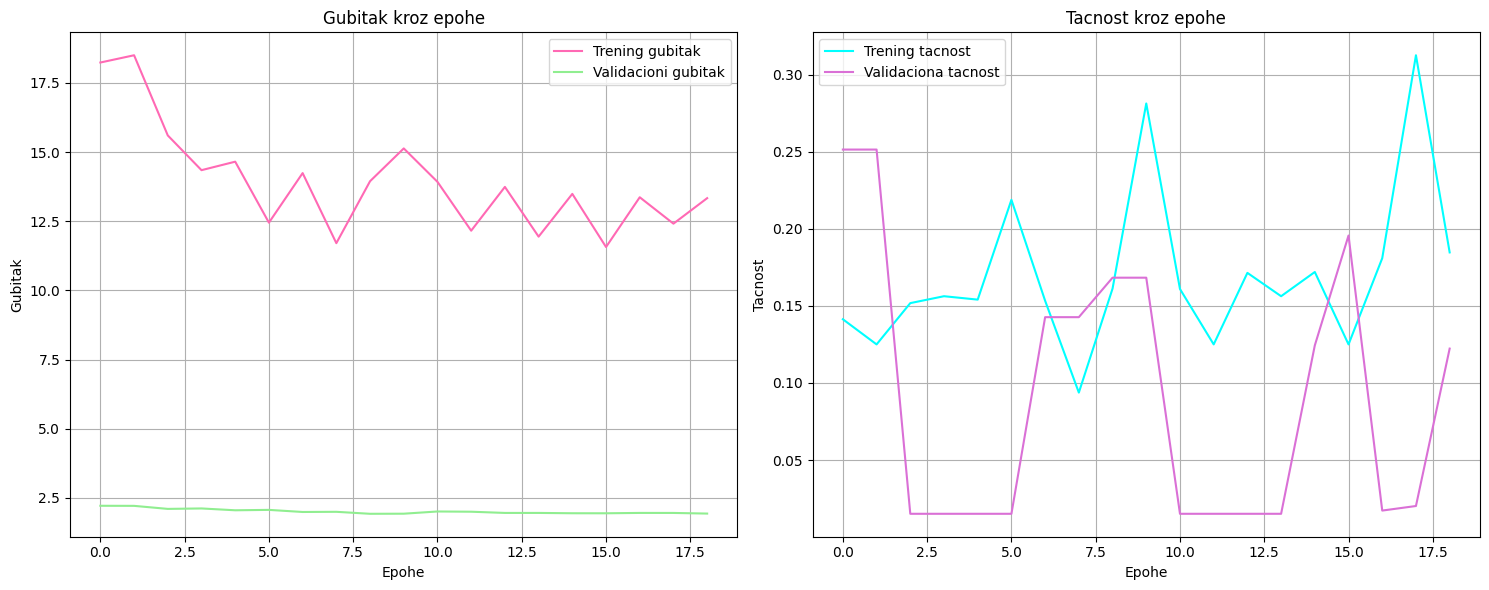

In [10]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(history.history['loss'], label='Trening gubitak', color='hotpink')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validacioni gubitak', color='lightgreen')
    axes[0].set_xlabel('Epohe')
    axes[0].set_ylabel('Gubitak')
    axes[0].set_title('Gubitak kroz epohe')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Trening tacnost', color='aqua')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validaciona tacnost', color='orchid')
    axes[1].set_xlabel('Epohe')
    axes[1].set_ylabel('Tacnost')
    axes[1].set_title('Tacnost kroz epohe')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0411 - loss: 1.9958
Test gubitak: 1.9265
Test tačnost: 0.1737


**Fine-tuning sa pravim brojem otključanih slojeva:**



In [12]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_layer_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_rel

In [16]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


<ipython-input-16-312530af6e07>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    class_weight = class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 59s 53ms/step - accuracy: 0.1787 - loss: 18.3364 - learning_rate: 1.0000e-04
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.2188 - loss: 13.0880 - learning_rate: 1.0000e-04
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


717/717 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.2317 - loss: 14.3749 - learning_rate: 1.0000e-04
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.1875 - loss: 12.7651 - learning_rate: 1.0000e-04
Epoch 5/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.2547 - loss: 12.9191 - learning_rate: 1.0000e-04
Epoch 6/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.2812 - loss: 13.6336 - learning_rate: 1.0000e-04
Epoch 7/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.2892 - loss: 12.3676 - learning_rate: 1.0000e-04
Epoch 8/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.2500 - loss: 11.8183 - learning_rate: 1.0000e-04
Epoch 9/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.3248 - loss: 11.8530 - learning_rate: 1.0000e-04
Epoch 10/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.3750 - loss: 9.5192 - learning_rate: 1.0000e-04
Epoch 11/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.3454 - los

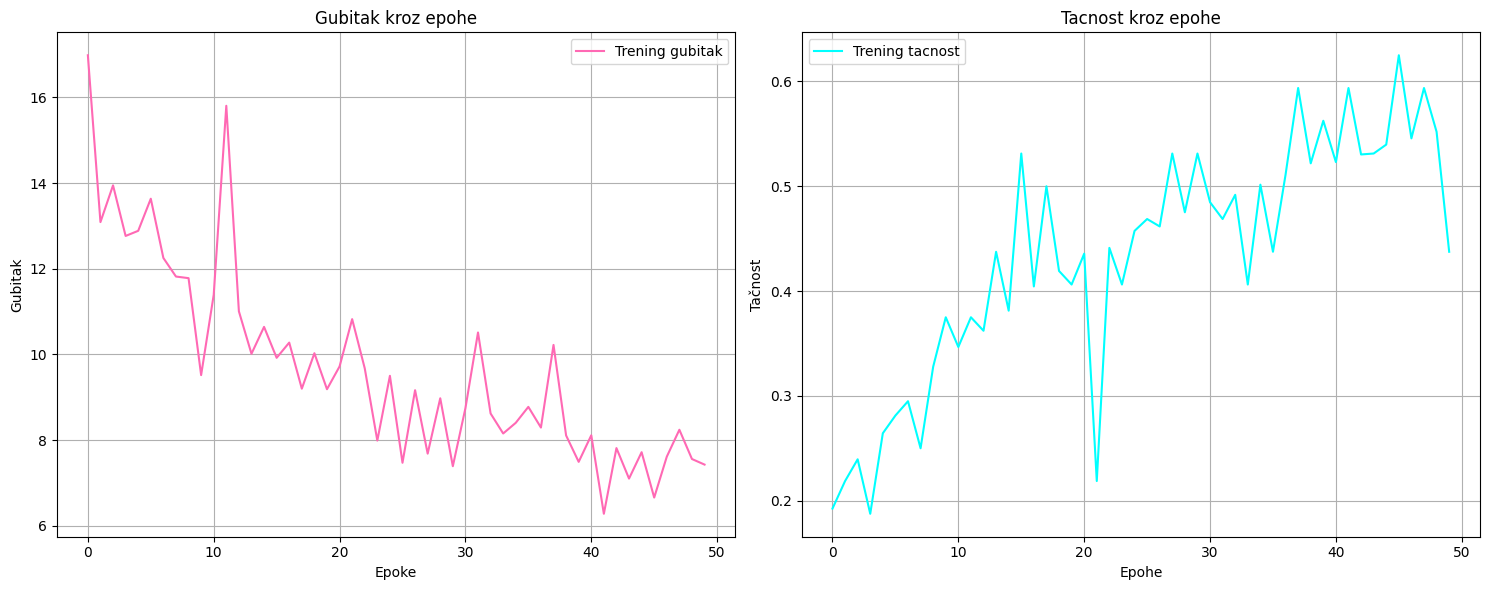

In [19]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(history.history['loss'], label='Trening gubitak', color='hotpink')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validacioni gubitak', color='lightgreen')
    axes[0].set_xlabel('Epoke')
    axes[0].set_ylabel('Gubitak')
    axes[0].set_title('Gubitak kroz epohe')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Trening tacnost', color='aqua')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validaciona tacnost', color='orchid')
    axes[1].set_xlabel('Epohe')
    axes[1].set_ylabel('Tačnost')
    axes[1].set_title('Tacnost kroz epohe')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4942 - loss: 1.3794
Test gubitak: 1.3047
Test tačnost: 0.5171


In [21]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = True
fine_tune_at = 80
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


<ipython-input-21-608e67e86e80>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


In [22]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    class_weight = class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.1652 - loss: 18.6614 - learning_rate: 1.0000e-04
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.2500 - loss: 13.4078 - learning_rate: 1.0000e-04
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.2192 - loss: 14.7694 - learning_rate: 1.0000e-04
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.2500 - loss: 10.1861 - learning_rate: 1.0000e-04
Epoch 5/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.2571 - loss: 13.2061 - learning_rate: 1.0000e-04
Epoch 6/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.3125 - loss: 12.2535 - learning_rate: 1.0000e-04
Epoch 7/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.3038 - loss: 12.1659 - learning_rate: 1.0000e-04
Epoch 8/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.4062 - loss: 15.1205 - learning_rate: 1.0000e-04
Epoch 9/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.

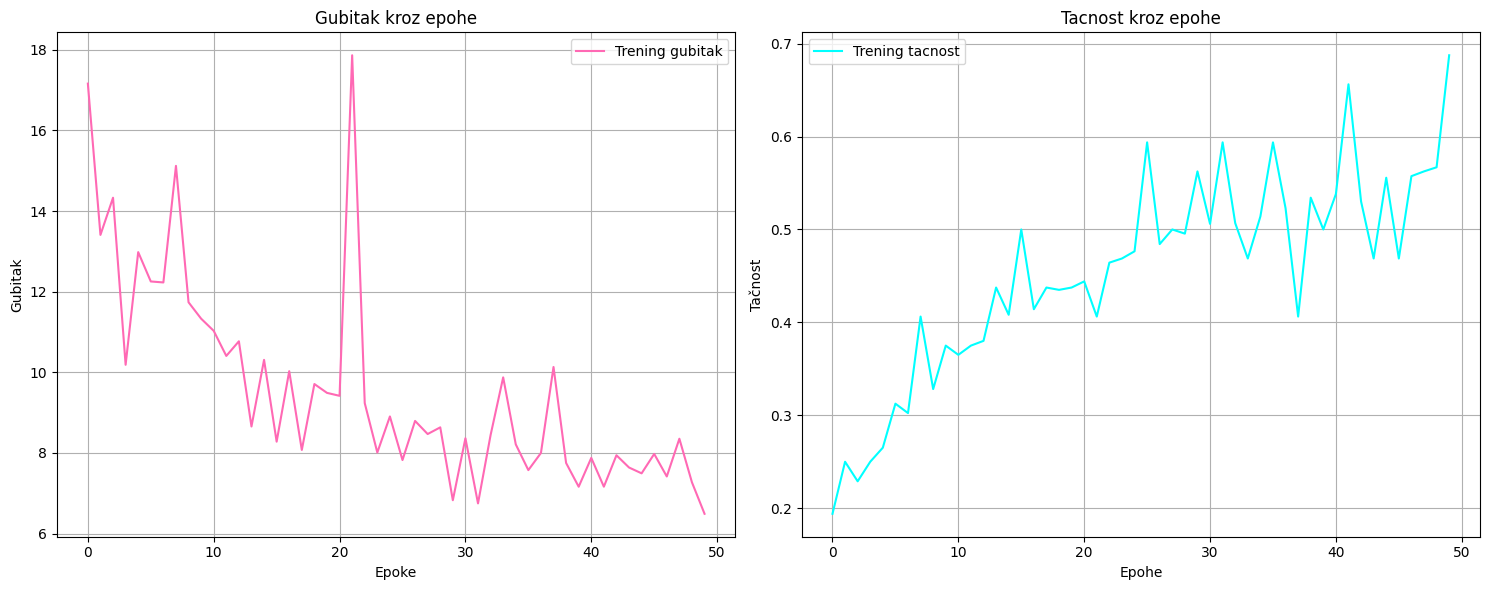

In [24]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(history.history['loss'], label='Trening gubitak', color='hotpink')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validacioni gubitak', color='lightgreen')
    axes[0].set_xlabel('Epoke')
    axes[0].set_ylabel('Gubitak')
    axes[0].set_title('Gubitak kroz epohe')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Trening tacnost', color='aqua')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validaciona tacnost', color='orchid')
    axes[1].set_xlabel('Epohe')
    axes[1].set_ylabel('Tačnost')
    axes[1].set_title('Tacnost kroz epohe')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [25]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4808 - loss: 1.4271
Test gubitak: 1.3188
Test tačnost: 0.5259


In [27]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    epochs=80,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    class_weight = class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)


<ipython-input-27-d02118920f02>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


Epoch 1/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.1718 - loss: 18.4737 - learning_rate: 1.0000e-04
Epoch 2/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.1562 - loss: 14.9348 - learning_rate: 1.0000e-04
Epoch 3/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.2133 - loss: 14.6287 - learning_rate: 1.0000e-04
Epoch 4/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.1250 - loss: 15.3302 - learning_rate: 1.0000e-04
Epoch 5/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.2463 - loss: 13.3281 - learning_rate: 1.0000e-04
Epoch 6/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.2188 - loss: 11.0458 - learning_rate: 1.0000e-04
Epoch 7/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.2818 - loss: 12.5224 - learning_rate: 1.0000e-04
Epoch 8/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.3750 - loss: 14.2372 - learning_rate: 1.0000e-04
Epoch 9/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.

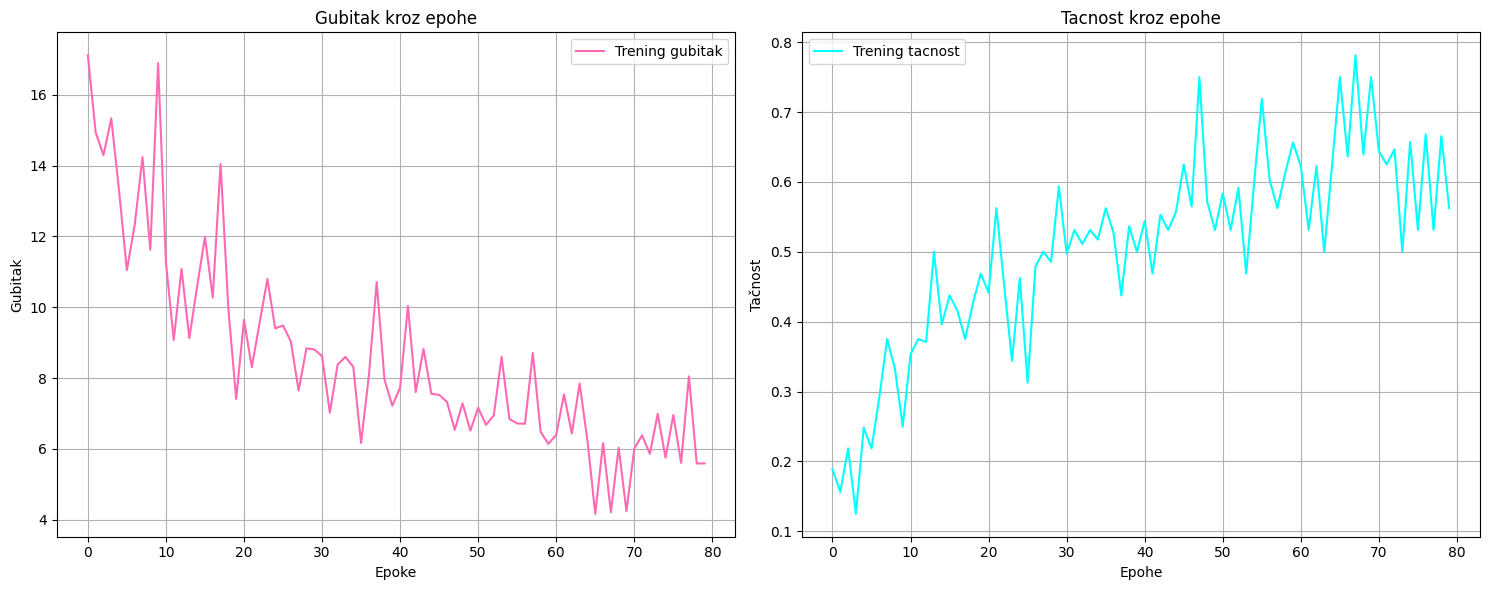

In [28]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(history.history['loss'], label='Trening gubitak', color='hotpink')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validacioni gubitak', color='lightgreen')
    axes[0].set_xlabel('Epoke')
    axes[0].set_ylabel('Gubitak')
    axes[0].set_title('Gubitak kroz epohe')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Trening tacnost', color='aqua')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validaciona tacnost', color='orchid')
    axes[1].set_xlabel('Epohe')
    axes[1].set_ylabel('Tačnost')
    axes[1].set_title('Tacnost kroz epohe')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [29]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5312 - loss: 1.3533
Test gubitak: 1.3655
Test tačnost: 0.5376


In [30]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = True
fine_tune_at = 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    epochs=80,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    class_weight = class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)


<ipython-input-30-3981da1963ce>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


Epoch 1/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.1737 - loss: 18.3576 - learning_rate: 1.0000e-04
Epoch 2/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.3438 - loss: 11.0865 - learning_rate: 1.0000e-04
Epoch 3/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.2316 - loss: 14.5026 - learning_rate: 1.0000e-04
Epoch 4/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.2188 - loss: 14.1448 - learning_rate: 1.0000e-04
Epoch 5/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.2675 - loss: 12.9793 - learning_rate: 1.0000e-04
Epoch 6/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.2812 - loss: 13.7210 - learning_rate: 1.0000e-04
Epoch 7/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3051 - loss: 12.1514 - learning_rate: 1.0000e-04
Epoch 8/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.3750 - loss: 10.3057 - learning_rate: 1.0000e-04
Epoch 9/80
717/717 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.

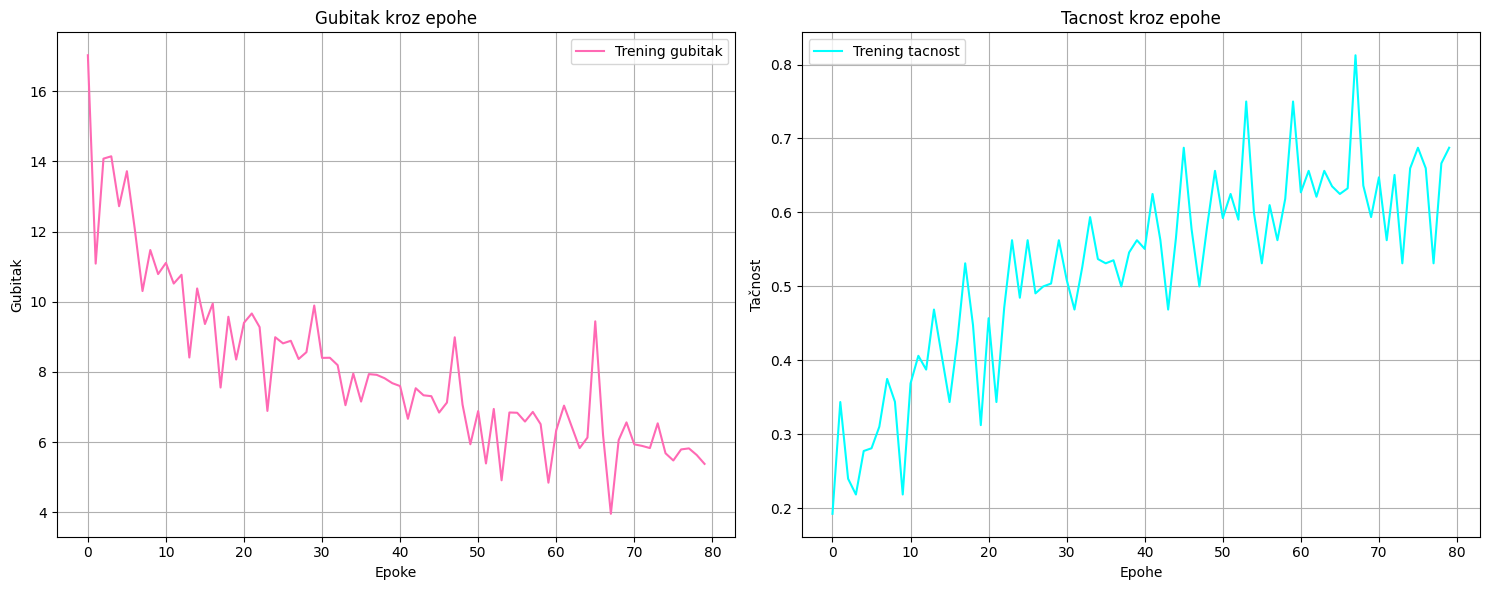

In [31]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(history.history['loss'], label='Trening gubitak', color='hotpink')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validacioni gubitak', color='lightgreen')
    axes[0].set_xlabel('Epoke')
    axes[0].set_ylabel('Gubitak')
    axes[0].set_title('Gubitak kroz epohe')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Trening tacnost', color='aqua')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validaciona tacnost', color='orchid')
    axes[1].set_xlabel('Epohe')
    axes[1].set_ylabel('Tačnost')
    axes[1].set_title('Tacnost kroz epohe')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5474 - loss: 1.2989
Test gubitak: 1.2975
Test tačnost: 0.5525
